In [1]:
import keras
import quandl
import numpy as np

from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input

import keras.backend as K
from sklearn.model_selection import KFold

%matplotlib inline

Using TensorFlow backend.


In [2]:
data = quandl.get('BCHARTS/BITFINEXUSD')

In [3]:
data.head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2013-03-31,93.250000,100.000000,93.03000,93.100000,390.827224,3.708933e+04,94.899563
2013-04-01,93.170000,105.900000,92.49999,102.370000,4919.654127,4.921010e+05,100.027564
2013-04-02,102.800000,118.388067,99.00000,117.989990,9084.832816,9.874119e+05,108.687953
2013-04-03,116.579097,146.880000,101.51088,134.952969,12909.402178,1.652092e+06,127.975861
2013-04-04,131.779686,143.000000,119.00000,132.681000,6910.100414,9.094385e+05,131.610029


In [15]:
print(data.shape)
#1363,7

mean = data.mean(axis=0)
std = data.std(axis=0)

# zscore normalization
data = ( data - mean ) / std

# # of days past 
d = 15

X = np.zeros((1363,d,7))

# embedding d days in each DP (deslocamento)
for i in range(d,data.shape[0]):
    X[i,:,:] = data.iloc[i-d:i].values

#removing first d lines, this ones didn't have d days past
X = X[d:,:,:]

print(X.shape)

(1363, 7)
(1348, 15, 7)


In [16]:
# criando as labels
Y = data['Weighted Price'] - data.shift(1)['Weighted Price']

Y.shape

(1363,)

In [17]:
Y = Y > 0

#retirando a primeira linha, pois a segunda label refere-se ao primeiro registro (variacao)
Y = Y[1:]

#retirando as d primeiras datas por causa do deslocamento
Y = Y[d:]

In [18]:
#retirando o ultimo registro das features para 
#especificando as outras dimensoes por boas praticas (nao esquecer a matriz)
X = X[: -1,:,:]

In [19]:
# checking shapes
Y.shape, X.shape

((1347,), (1347, 15, 7))

In [20]:
# passando pro formato de 4 dimensoes esperadas
X = X.reshape((Y.shape[0],d,7,1))

In [21]:
# train / test split
#X_train = X[:-300,:,:,:]
#X_test = X[-300:,:,:,:]
#Y_train = Y[:-300]
#Y_test = Y[-300:]

# trying some cross validation
kf = KFold(n_splits=8,shuffle=True,random_state=0)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    #print("TRAIN:", train_index, "TEST:", test_index)

In [22]:
def model(input_shape):
    
    X_input = Input(input_shape)
    
    #padding same pra nao reduzir 
    X = Conv2D(10,(3,3), strides=(1,1),name="conv0", padding="same")(X_input)
    X = BatchNormalization(axis=3,name='bn0')(X)
    X = Activation('relu')(X)

    X = MaxPooling2D((2,2),name='max_pool0')(X)
    
    #Second conv
    X = Conv2D(30,(2,2), strides=(1,1),name="conv1", padding="same")(X)
    X = BatchNormalization(axis=3,name='bn1')(X)
    X = Activation('relu')(X)

    X = MaxPooling2D((2,2),name='max_pool1')(X)
    
    #Third conv
    #X = Conv2D(50,(1,1), strides=(1,1),name="conv2", padding="same")(X)
    #X = BatchNormalization(axis=3,name='bn2')(X)
    #X = Activation('relu')(X)
    
    #fcs
    X = Flatten()(X)
    X = Dense(200,activation="relu")(X)
    X = Dense(100,activation="relu")(X)
    X = Dense(50,activation="relu")(X)
    X = Dense(1,activation="sigmoid")(X)
    
    model = Model(inputs=X_input,outputs=X, name="model1")
    
    return model

In [23]:
#instanciando modelo
model = model(X[0].shape)

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=["accuracy"])

model.fit(x = X_train, y = Y_train, epochs = 200, batch_size = 8,verbose=1)

Epoch 1/200
1179/1179 [==============================] - 1s 975us/step - loss: 0.7050 - acc: 0.5004
Epoch 2/200
1179/1179 [==============================] - 1s 811us/step - loss: 0.6884 - acc: 0.5411
Epoch 3/200
1179/1179 [==============================] - 1s 716us/step - loss: 0.6895 - acc: 0.5428
Epoch 4/200
1179/1179 [==============================] - 1s 803us/step - loss: 0.6876 - acc: 0.5479
Epoch 5/200
1179/1179 [==============================] - 1s 688us/step - loss: 0.6867 - acc: 0.5437
Epoch 6/200
1179/1179 [==============================] - 1s 700us/step - loss: 0.6792 - acc: 0.5462
Epoch 7/200
1179/1179 [==============================] - 1s 808us/step - loss: 0.6751 - acc: 0.5827
Epoch 8/200
1179/1179 [==============================] - 1s 710us/step - loss: 0.6790 - acc: 0.5751
Epoch 9/200
1179/1179 [==============================] - 1s 847us/step - loss: 0.6662 - acc: 0.5878
Epoch 10/200
1179/1179 [==============================] - 1s 707us/step - loss: 0.6581 - acc: 0.6005

1179/1179 [==============================] - 1s 972us/step - loss: 0.1688 - acc: 0.9211
Epoch 83/200
1179/1179 [==============================] - 1s 924us/step - loss: 0.1826 - acc: 0.9228
Epoch 84/200
1179/1179 [==============================] - 1s 789us/step - loss: 0.2113 - acc: 0.9109
Epoch 85/200
1179/1179 [==============================] - 1s 601us/step - loss: 0.1456 - acc: 0.9355
Epoch 86/200
1179/1179 [==============================] - 1s 703us/step - loss: 0.1454 - acc: 0.9271
Epoch 87/200
1179/1179 [==============================] - 1s 721us/step - loss: 0.1333 - acc: 0.9347
Epoch 88/200
1179/1179 [==============================] - 1s 754us/step - loss: 0.1503 - acc: 0.9347
Epoch 89/200
1179/1179 [==============================] - 1s 843us/step - loss: 0.1295 - acc: 0.9330
Epoch 90/200
1179/1179 [==============================] - 1s 1ms/step - loss: 0.1596 - acc: 0.9271
Epoch 91/200
1179/1179 [==============================] - 1s 882us/step - loss: 0.1419 - acc: 0.9304
Epoch

1179/1179 [==============================] - 1s 817us/step - loss: 0.0923 - acc: 0.9584
Epoch 163/200
1179/1179 [==============================] - 1s 741us/step - loss: 0.1159 - acc: 0.9517
Epoch 164/200
1179/1179 [==============================] - 1s 836us/step - loss: 0.1152 - acc: 0.9474
Epoch 165/200
1179/1179 [==============================] - 1s 809us/step - loss: 0.0923 - acc: 0.9559
Epoch 166/200
1179/1179 [==============================] - 1s 861us/step - loss: 0.0635 - acc: 0.9712
Epoch 167/200
1179/1179 [==============================] - 1s 759us/step - loss: 0.0638 - acc: 0.9720
Epoch 168/200
1179/1179 [==============================] - 1s 818us/step - loss: 0.0645 - acc: 0.9661
Epoch 169/200
1179/1179 [==============================] - 1s 763us/step - loss: 0.1014 - acc: 0.9559
Epoch 170/200
1179/1179 [==============================] - 1s 730us/step - loss: 0.1524 - acc: 0.9355
Epoch 171/200
1179/1179 [==============================] - 1s 802us/step - loss: 0.1149 - acc: 0

In [26]:
preds = model.evaluate(x = X_test, y = Y_test)
print()
print("Loss = " + str(preds[0]))
print("Acc = " + str(preds[1]))

168/168 [==============================] - 0s 254us/step

Loss = 3.61613048826
Acc = 0.5


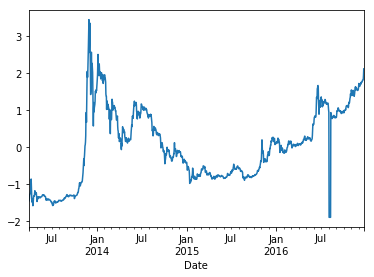

In [25]:
data['Weighted Price'].plot()